This notebook illustrates how to best determine the starting location (position to extract segment for interferogram formation)
of other columns once the start position of the central column has been determined. 

In [38]:
# vital imports
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, IntSlider, interact, Label

from c_hyti_proc import *

%matplotlib inline

First read in the data for a blackbody. Then process the central column of data.

In [39]:
hyti=c_hyti_proc(324,256)
datadir='/Users/hg/workdir/hyti_proc_notebook/data/'
# bb files
bb90=datadir+'TIR-180924120627-bb90-scan.bsqmn'
bb60=datadir+'TIR-180924125013-bb60-scan.bsqmn'
# wavecals 
wc_9724=datadir+'wc_9724'


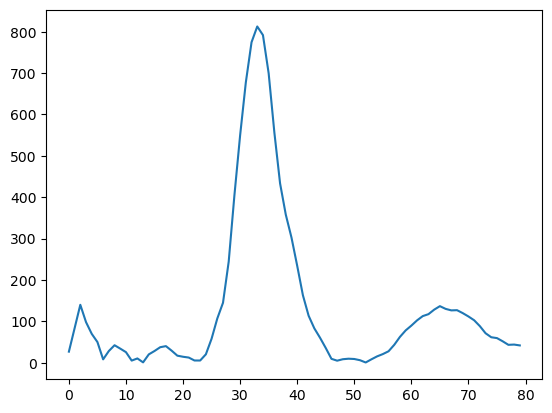

In [40]:
#for now read in only the hot bb
bb90_flatten=hyti.extract_flatten(bb90)
# extract and zoom it up by factor of 8x
bb90_mid=bb90_flatten[:,160]
bb90_midzm=hyti.sp_interpolate(bb90_mid,8)
# use a start point for central column of 36.3
bb90_midseg=hyti.extract(bb90_midzm,8,36.3,200)
# and process
bb90_midproc=hyti.proc_tircis(bb90_midseg,0)

plt.plot(bb90_midproc[0:80])
plt.show()

Now read in a column closer to the edge of the image and process.


In [42]:
# add in a slider and find best start point for the column to the left of the image.
# for bb90_left, choose a column towards left of image



def update_procleft(starts, startcol):
    bb90_left=bb90_flatten[:,startcol]
    bb90_leftzm=hyti.sp_interpolate(bb90_left,8)
    bb90_leftseg=hyti.extract(bb90_leftzm,8,starts,200)
    # and process
    bb90_leftproc=hyti.proc_tircis(bb90_leftseg,0)
    corrvalue = np.corrcoef(bb90_midproc[20:50],bb90_leftproc[20:50])
    outtextcnt.value=corrvalue[0,1]
    # plot vs. the central column result
    plt.plot(bb90_midproc[0:80])
    plt.plot(bb90_leftproc[0:80])
    plt.show()

interact(update_procleft, starts=FloatSlider(min=35.0, max=38.0, step=.1, value=36.3, description="Start Location"),
         startcol=IntSlider(min=0, max=324.0, step=1, value=40, description="Match Column"));

    




interactive(children=(FloatSlider(value=36.3, description='Start Location', max=38.0, min=35.0), IntSlider(val…

In the above cell, it can be shown if you use the 36.3 that was used for the
starting point for the central column, we do not get a great match. Selecting the value
of 35.9 gives a much better match. This can be repeated for each column in the image, which would be one way to arrive at the "segs.off" file, ie one value for each column. Or this can be automated by going through each column, then iterating starting location to get the best fit, saving the best fit start location, then moving to the next column. 

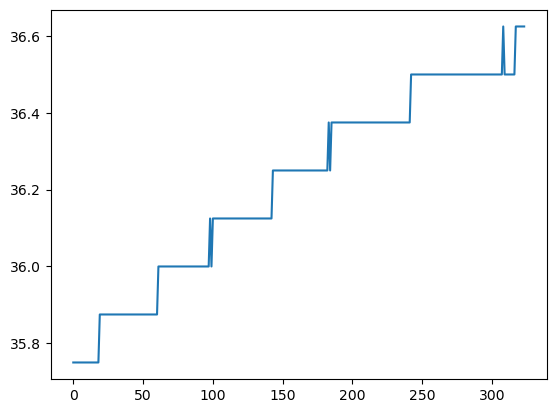

In [52]:
# This automates the match process by looping through each column and iterating through starting locations from 35 to 37 at 1/8th 
# pixel step size.
startloc = np.zeros(324,dtype=np.float32)
for icol in range(324):
    maxval = -10.
    maxstart = 0.
    bb90_left=bb90_flatten[:,icol]
    bb90_leftzm=hyti.sp_interpolate(bb90_left,8)
    for starts in np.arange(35,37,.125) :        
        bb90_leftseg=hyti.extract(bb90_leftzm,8,starts,200)
        # and process
        bb90_leftproc=hyti.proc_tircis(bb90_leftseg,0)
        corrvalue = np.corrcoef(bb90_midproc[20:50],bb90_leftproc[20:50])[0,1]
        if (corrvalue > maxval):
            maxval = corrvalue
            maxstart = starts
    startloc[icol]=maxstart
plt.plot(startloc)
plt.show()
        
        